In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# added import inspector
from sqlalchemy import inspect

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# #Attempted to dynamically save references. This method worked, but I was cautioned about using 'exec()'
# table_dict = {}
# for key in Base.classes.keys():
#     x = f"table_dict['{key}']=Base.classes.{key}"
#     exec(x) #exec method discovered at https://www.w3schools.com/python/ref_func_exec.asp
#     #adapted by me for the inclusion of the "key" variable here by me. Good job, me.
# table_dict
# [print(key+": "+' '.join(map(str,dir( table_dict[key])))) for key in Base.classes.keys()]
# # string to list method from https://www.geeksforgeeks.org/python-program-to-convert-a-list-to-string/

In [9]:
# Save references to each table
# Recreate above using sql "inspector"
inspector = inspect(engine)
for table in inspector.get_table_names():
    vars()[table.title()] = Base.classes[table] # Use [table] instead of Base.classes.table, which would not work.
    print("Table Name: " + table)
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])
    print("----------------")
# This is a cleaner method and avoids using "exec()" which is vulnerable/not production quality.

Table Name: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------------
Table Name: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
----------------


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
meas_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
meas_latest_date[0]

'2017-08-23'

<AxesSubplot:title={'center':'12 Months Precipitation by Date'}, xlabel='date', ylabel='observed precipitation (inches)'>

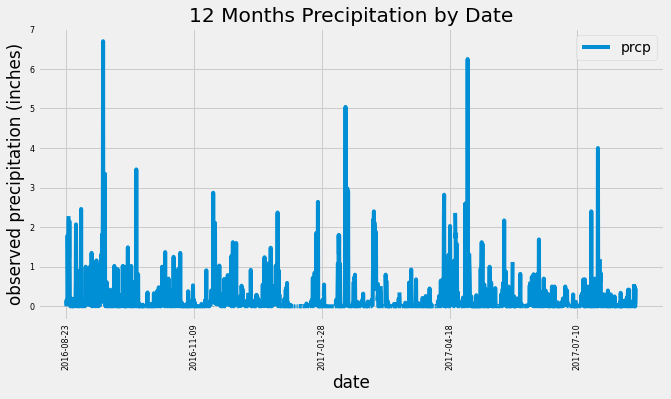

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculated above.

# Calculate the date one year from the last date in data set.
# From "2017-08-23" 12 mos would be to "2016-08-24" 

# Perform a query to retrieve the data and precipitation scores
meas_recent = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    order_by(Measurement.date.asc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
meas_recent_df = pd.DataFrame(meas_recent)
meas_recent_df = meas_recent_df.set_index("date",drop=True)
# Sort the dataframe by date (already done with query)
meas_recent_df

# Use Pandas Plotting with Matplotlib to plot the data
meas_recent_df.plot(rot=90,fontsize=8,figsize = (10,5),\
                    title="12 Months Precipitation by Date",\
                   ylabel = "observed precipitation (inches)")



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
meas_recent_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count()
print("There are " + str(station_count) + " stations.")

There are 9 stations.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_st = active_stations[0][0]
active_st_temps_query=session.query(Measurement.tobs).filter(Measurement.station == most_active_st).all()
active_st_temps_unpack = [temp[0] for temp in active_st_temps_query]
print("The lowest temperature observed at "+ most_active_st +" is " + str(min(active_st_temps_unpack))+".")
print("The highest temperature observed at "+ most_active_st +" is " + str(max(active_st_temps_unpack))+".")
print("The average temperature observed at "+ most_active_st +" is " + str(round(sum(active_st_temps_unpack)/len(active_st_temps_unpack),1))+".")

The lowest temperature observed at USC00519281 is 54.0.
The highest temperature observed at USC00519281 is 85.0.
The average temperature observed at USC00519281 is 71.7.


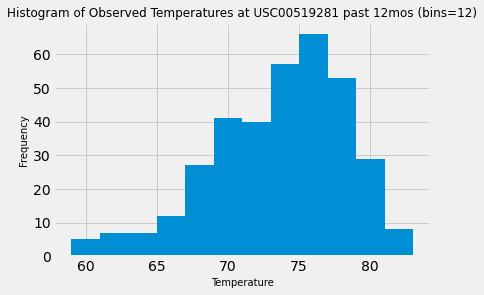

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_recent_active_st = session.query(Measurement.tobs).filter(Measurement.date >= "2016-08-23")\
                                                                    .filter(Measurement.station == most_active_st).all()
temp_recent_active_st_unpack = [temp[0] for temp in temp_recent_active_st]
bins = 12 # per readme
plt.hist(temp_recent_active_st_unpack, bins)
plt.title(f"Histogram of Observed Temperatures at {most_active_st} past 12mos (bins={bins})",fontsize = 12)
plt.xlabel("Temperature",fontsize = 10)
plt.ylabel("Frequency",fontsize = 10)
plt.show()

# Close session

In [18]:
# Close Session
session.close()